In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/repos/YOLOv3/


/content/drive/MyDrive/repos/YOLOv3


In [4]:
ls 'dataset/LE_cand1/'

cand1.csv       LEs_name.txt          tiles/            tiles_star/
df_cand1.csv    test_aug2.txt         tiles_all/        train_aug2.txt
LE_all_aug.txt  test_aug_addstar.txt  tiles_aug/        train_aug.txt
LE_all.txt      test_aug.txt          tiles_aug_noise/


In [3]:
%%writefile yolov3/configs.py
#================================================================
#
#   File name   : configs.py
#   Author      : PyLessons
#   Created date: 2020-06-04
#   Website     : https://pylessons.com/
#   GitHub      : https://github.com/pythonlessons/TensorFlow-2.x-YOLOv3
#   Description : yolov3 configuration file
#
#================================================================

# YOLO options
YOLO_DARKNET_WEIGHTS        = "model_data/yolov3.weights"
YOLO_DARKNET_TINY_WEIGHTS   = "model_data/yolov3-tiny.weights"
YOLO_COCO_CLASSES           = "model_data/coco.names"
YOLO_STRIDES                = [8, 16, 32]
YOLO_IOU_LOSS_THRESH        = 0.5
YOLO_ANCHOR_PER_SCALE       = 3
YOLO_MAX_BBOX_PER_SCALE     = 100
YOLO_INPUT_SIZE             = 576
#YOLO_INPUT_SIZE             = 800
YOLO_ANCHORS                = [[[10,  13], [16,   30], [33,   23]],
                               [[30,  61], [62,   45], [59,  119]],
                               [[116, 90], [156, 198], [373, 326]]]
# Train options
TRAIN_YOLO_TINY             = False
TRAIN_SAVE_BEST_ONLY        = True # saves only best model according validation loss (True recommended)
TRAIN_SAVE_CHECKPOINT       = False # saves all best validated checkpoints in training process (may require a lot disk space) (False recommended)
#TRAIN_CLASSES               = "mnist/mnist.names"
TRAIN_CLASSES               = "dataset/LE_cand1/LEs_name.txt"
#TRAIN_ANNOT_PATH            = "mnist/mnist_train.txt"
TRAIN_ANNOT_PATH            = "dataset/LE_cand1/train_aug2.txt"
TRAIN_LOGDIR                = "log"
TRAIN_CHECKPOINTS_FOLDER    = "checkpoints"
TRAIN_MODEL_NAME            = "model"
TRAIN_LOAD_IMAGES_TO_RAM    = False # faster training, but need more RAM
#TRAIN_BATCH_SIZE            = 8
TRAIN_BATCH_SIZE            = 4
TRAIN_INPUT_SIZE            = 576
TRAIN_DATA_AUG              = False
TRAIN_TRANSFER              = False
TRAIN_FROM_CHECKPOINT       = False # "checkpoints/yolov3_custom_2"
TRAIN_LR_INIT               = 1e-4
TRAIN_LR_END                = 1e-6
TRAIN_WARMUP_EPOCHS         = 2
TRAIN_EPOCHS                = 100

# TEST options
TEST_ANNOT_PATH             = "dataset/LE_cand1/test_aug2.txt"
TEST_BATCH_SIZE             = 4
TEST_INPUT_SIZE             = 576
TEST_DATA_AUG               = False
TEST_DECTECTED_IMAGE_PATH   = ""
TEST_SCORE_THRESHOLD        = 0.3
TEST_IOU_THRESHOLD          = 0.45

#YOLOv3-TINY WORKAROUND
if TRAIN_YOLO_TINY:
    YOLO_STRIDES            = [16, 32, 64]    
    YOLO_ANCHORS            = [[[10,  14], [23,   27], [37,   58]],
                               [[81,  82], [135, 169], [344, 319]],
                               [[0,    0], [0,     0], [0,     0]]]


Overwriting yolov3/configs.py


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
import tensorflow as tf
#from tensorflow.keras.utils import plot_model
from yolov3.dataset import Dataset
#from yolov3.yolov3 import Create_Yolov3, YOLOv3, decode, compute_loss
from yolov3.utils import load_yolo_weights#, load_tiny_yolo_weights
#from yolov3.configs import *


### create yolo define loss

In [5]:
#================================================================
#
#   File name   : yolov3.py
#   Author      : PyLessons
#   Created date: 2020-06-04
#   Website     : https://pylessons.com/
#   GitHub      : https://github.com/pythonlessons/TensorFlow-2.x-YOLOv3
#   Description : main yolov3 functions
#
#================================================================
#import numpy as np
#import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, ZeroPadding2D, BatchNormalization, MaxPool2D
from tensorflow.keras.regularizers import l2
from yolov3.utils import read_class_names
from yolov3.configs import *

STRIDES         = np.array(YOLO_STRIDES)
ANCHORS         = (np.array(YOLO_ANCHORS).T/STRIDES).T

class BatchNormalization(BatchNormalization):
    # "Frozen state" and "inference mode" are two separate concepts.
    # `layer.trainable = False` is to freeze the layer, so the layer will use
    # stored moving `var` and `mean` in the "inference mode", and both `gama`
    # and `beta` will not be updated !
    def call(self, x, training=False):
        if not training:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

def convolutional(input_layer, filters_shape, downsample=False, activate=True, bn=True):
    if downsample:
        input_layer = ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
        padding = 'valid'
        strides = 2
    else:
        strides = 1
        padding = 'same'

    conv = Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], strides=strides,
                  padding=padding, use_bias=not bn, kernel_regularizer=l2(0.0005),
                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                  bias_initializer=tf.constant_initializer(0.))(input_layer)
    if bn:
        conv = BatchNormalization()(conv)
    if activate == True:
        conv = LeakyReLU(alpha=0.1)(conv)

    return conv

def residual_block(input_layer, input_channel, filter_num1, filter_num2):
    short_cut = input_layer
    conv = convolutional(input_layer, filters_shape=(1, 1, input_channel, filter_num1))
    conv = convolutional(conv       , filters_shape=(3, 3, filter_num1,   filter_num2))

    residual_output = short_cut + conv
    return residual_output

def upsample(input_layer):
    return tf.image.resize(input_layer, (input_layer.shape[1] * 2, input_layer.shape[2] * 2), method='nearest')


def darknet53(input_data):
    input_data = convolutional(input_data, (3, 3,  3,  32))
    input_data = convolutional(input_data, (3, 3, 32,  64), downsample=True)

    for i in range(1):
        input_data = residual_block(input_data,  64,  32, 64)

    input_data = convolutional(input_data, (3, 3,  64, 128), downsample=True)

    for i in range(2):
        input_data = residual_block(input_data, 128,  64, 128)

    input_data = convolutional(input_data, (3, 3, 128, 256), downsample=True)

    for i in range(8):
        input_data = residual_block(input_data, 256, 128, 256)

    route_1 = input_data
    input_data = convolutional(input_data, (3, 3, 256, 512), downsample=True)

    for i in range(8):
        input_data = residual_block(input_data, 512, 256, 512)

    route_2 = input_data
    input_data = convolutional(input_data, (3, 3, 512, 1024), downsample=True)

    for i in range(4):
        input_data = residual_block(input_data, 1024, 512, 1024)

    return route_1, route_2, input_data

def darknet19_tiny(input_data):
    input_data = convolutional(input_data, (3, 3, 3, 16))
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 16, 32))
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 32, 64))
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 64, 128))
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 128, 256))
    route_1 = input_data
    input_data = MaxPool2D(2, 2, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 256, 512))
    input_data = MaxPool2D(2, 1, 'same')(input_data)
    input_data = convolutional(input_data, (3, 3, 512, 1024))

    return route_1, input_data

def YOLOv3(input_layer, NUM_CLASS):
    # After the input layer enters the Darknet-53 network, we get three branches
    route_1, route_2, conv = darknet53(input_layer)
    # See the orange module (DBL) in the figure above, a total of 5 Subconvolution operation
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv = convolutional(conv, (3, 3,  512, 1024))
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv = convolutional(conv, (3, 3,  512, 1024))
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv_lobj_branch = convolutional(conv, (3, 3, 512, 1024))
    
    # conv_lbbox is used to predict large-sized objects , Shape = [None, 13, 13, 255] 
    conv_lbbox = convolutional(conv_lobj_branch, (1, 1, 1024, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1,  512,  256))
    # upsample here uses the nearest neighbor interpolation method, which has the advantage that the
    # upsampling process does not need to learn, thereby reducing the network parameter  
    conv = upsample(conv)

    conv = tf.concat([conv, route_2], axis=-1)
    conv = convolutional(conv, (1, 1, 768, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv_mobj_branch = convolutional(conv, (3, 3, 256, 512))

    # conv_mbbox is used to predict medium-sized objects, shape = [None, 26, 26, 255]
    conv_mbbox = convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1, 256, 128))
    conv = upsample(conv)

    conv = tf.concat([conv, route_1], axis=-1)
    conv = convolutional(conv, (1, 1, 384, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv_sobj_branch = convolutional(conv, (3, 3, 128, 256))
    
    # conv_sbbox is used to predict small size objects, shape = [None, 52, 52, 255]
    conv_sbbox = convolutional(conv_sobj_branch, (1, 1, 256, 3*(NUM_CLASS +5)), activate=False, bn=False)
        
    return [conv_sbbox, conv_mbbox, conv_lbbox]

def YOLOv3_tiny(input_layer, NUM_CLASS):
    # After the input layer enters the Darknet-53 network, we get three branches
    route_1, conv = darknet19_tiny(input_layer)

    conv = convolutional(conv, (1, 1, 1024, 256))
    conv_lobj_branch = convolutional(conv, (3, 3, 256, 512))
    
    # conv_lbbox is used to predict large-sized objects , Shape = [None, 26, 26, 255]
    conv_lbbox = convolutional(conv_lobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1, 256, 128))
    # upsample here uses the nearest neighbor interpolation method, which has the advantage that the
    # upsampling process does not need to learn, thereby reducing the network parameter  
    conv = upsample(conv)
    
    conv = tf.concat([conv, route_1], axis=-1)
    conv_mobj_branch = convolutional(conv, (3, 3, 128, 256))
    # conv_mbbox is used to predict medium size objects, shape = [None, 13, 13, 255]
    conv_mbbox = convolutional(conv_mobj_branch, (1, 1, 256, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    return [conv_mbbox, conv_lbbox]

def Create_Yolov3(input_size=416, channels=3, training=False, CLASSES=YOLO_COCO_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    input_layer  = Input([input_size, input_size, channels])

    if TRAIN_YOLO_TINY:
        conv_tensors = YOLOv3_tiny(input_layer, NUM_CLASS)
    else:
        conv_tensors = YOLOv3(input_layer, NUM_CLASS)

    output_tensors = []
    for i, conv_tensor in enumerate(conv_tensors):
        pred_tensor = decode(conv_tensor, NUM_CLASS, i)
        if training: output_tensors.append(conv_tensor)
        output_tensors.append(pred_tensor)

    YoloV3 = tf.keras.Model(input_layer, output_tensors)
    return YoloV3

def decode(conv_output, NUM_CLASS, i=0):
    # where i = 0, 1 or 2 to correspond to the three grid scales  
    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy = conv_output[:, :, :, :, 0:2] # offset of center position     
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4] # Prediction box length and width offset
    conv_raw_conf = conv_output[:, :, :, :, 4:5] # confidence of the prediction box
    conv_raw_prob = conv_output[:, :, :, :, 5: ] # category probability of the prediction box 

    # next need Draw the grid. Where output_size is equal to 13, 26 or 52  
    y = tf.range(output_size, dtype=tf.int32)
    y = tf.expand_dims(y, -1)
    y = tf.tile(y, [1, output_size])
    x = tf.range(output_size,dtype=tf.int32)
    x = tf.expand_dims(x, 0)
    x = tf.tile(x, [output_size, 1])

    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    # Calculate the center position of the prediction box:
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
    # Calculate the length and width of the prediction box:
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]

    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.sigmoid(conv_raw_conf) # object box calculates the predicted confidence
    pred_prob = tf.sigmoid(conv_raw_prob) # calculating the predicted probability category box object

    # calculating the predicted probability category box object
    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

def bbox_iou(boxes1, boxes2):
    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    print("compute iou......")
    return 1.0 * inter_area / union_area


def bbox_niou(boxes1, boxes2):
    #print("compute bbox_iou")
    # box [x, y, w, h], x,y: center of box
    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]
    
    #[, 4]
    global Pred_xywh, Label_xywh, BOX1, BOX2
    Pred_xywh = boxes1
    Label_xywh = boxes2

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1) 

    # output 
    BOX1 = boxes1
    BOX2 = boxes2
    #print('boxes1',  boxes1.shape)
    #print('boxes2', boxes2.shape)

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    iou = 1.0 * inter_area / union_area
    # add N_corner term
    # boxes2 contains boxes1 
    idx_4corners_2in1 = ( boxes1[..., 0] > boxes2[..., 0] ) & ( boxes1[..., 3] < boxes2[..., 3] ) \
                & ( boxes1[..., 1] > boxes2[..., 1]) & ( boxes1[..., 2] < boxes2[..., 2] )

    #idx_4corners_1in2 = ( boxes2[..., 0] > boxes1[..., 0] ) & ( boxes2[..., 3] < boxes1[..., 3] ) \
    #            & ( boxes2[..., 1] > boxes1[..., 1]) & ( boxes2[..., 2] < boxes1[..., 2] )
    
    #idx_4corners = idx_4corners_2in1 | idx_4corners_1in2
    print("compute niou ...")
    #return 1.0 * inter_area / union_area
    #return iou + tf.cast( idx_4corners_2in1, tf.float32 )
    # change iou value to 1 if label contains pred
    idx_float = tf.cast( idx_4corners_2in1, tf.float32 )
    niou = iou * ( 1 - idx_float ) + idx_float  # change iou to one if idx=True
    #niou = iou + idx_float
    return niou

def bbox_giou(boxes1, boxes2):
    print("compute bbox_giou")
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    # Calculate the iou value between the two bounding boxes
    iou = inter_area / union_area

    # Calculate the coordinates of the upper left corner and the lower right corner of the smallest closed convex surface
    enclose_left_up = tf.minimum(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = tf.maximum(boxes1[..., 2:], boxes2[..., 2:])
    enclose = tf.maximum(enclose_right_down - enclose_left_up, 0.0)

    # Calculate the area of the smallest closed convex surface C
    enclose_area = enclose[..., 0] * enclose[..., 1]

    # Calculate the GIoU value according to the GioU formula  
    giou = iou - 1.0 * (enclose_area - union_area) / enclose_area

    return giou

def bbox_iop(boxes1, boxes2):
    #print("compute bbox_iou")
    # box [x, y, w, h], x,y: center of box
    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]
    
    #[, 4]
    global Pred_xywh, Label_xywh, BOX1, BOX2
    Pred_xywh = boxes1
    Label_xywh = boxes2

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1) 

    # output 
    BOX1 = boxes1
    BOX2 = boxes2
    #print('boxes1',  boxes1.shape)
    #print('boxes2', boxes2.shape)

    print("compute box_iop")
    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    iop = 1.0 * inter_area / boxes1_area

    return iop


# testing (should be better than giou)
def bbox_ciou(boxes1, boxes2):
    
    boxes1_coor = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2_coor = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left = tf.maximum(boxes1_coor[..., 0], boxes2_coor[..., 0])
    up = tf.maximum(boxes1_coor[..., 1], boxes2_coor[..., 1])
    right = tf.maximum(boxes1_coor[..., 2], boxes2_coor[..., 2])
    down = tf.maximum(boxes1_coor[..., 3], boxes2_coor[..., 3])

    c = (right - left) * (right - left) + (up - down) * (up - down)
    iou = bbox_iou(boxes1, boxes2)

    u = (boxes1[..., 0] - boxes2[..., 0]) * (boxes1[..., 0] - boxes2[..., 0]) + (boxes1[..., 1] - boxes2[..., 1]) * (boxes1[..., 1] - boxes2[..., 1])
    d = u / c

    ar_gt = boxes2[..., 2] / boxes2[..., 3]
    ar_pred = boxes1[..., 2] / boxes1[..., 3]

    ar_loss = 4 / (np.pi * np.pi) * (tf.atan(ar_gt) - tf.atan(ar_pred)) * (tf.atan(ar_gt) - tf.atan(ar_pred))
    alpha = ar_loss / (1 - iou + ar_loss + 0.000001)
    ciou_term = d + alpha * ar_loss
    
    print("compute ciou")
    return iou - ciou_term

def compute_loss(pred, conv, label, bboxes, i=0, CLASSES=YOLO_COCO_CLASSES, ioutype='mIoU'):
    NUM_CLASS = len(read_class_names(CLASSES))
    conv_shape  = tf.shape(conv)
    batch_size  = conv_shape[0]
    output_size = conv_shape[1]
    input_size  = STRIDES[i] * output_size
    conv = tf.reshape(conv, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_conf = conv[:, :, :, :, 4:5]
    conv_raw_prob = conv[:, :, :, :, 5:]

    pred_xywh     = pred[:, :, :, :, 0:4]
    pred_conf     = pred[:, :, :, :, 4:5]

    label_xywh    = label[:, :, :, :, 0:4]  # xywh,
    respond_bbox  = label[:, :, :, :, 4:5]  # label whether a box contains objects
    label_prob    = label[:, :, :, :, 5:]   # label class, dimension= Number of class 

    #giou = tf.expand_dims( bbox_giou(pred_xywh, label_xywh), axis=-1)
    
    # change to iou loss
    print("compute loss")
    #print("pred_xywh", pred_xywh.shape, )
    #print("label_xywh", label_xywh.shape, )
    # different type of iou functions
    dic_iou = {'IoU':bbox_iou, 'mIoU':bbox_niou, 
               'GIoU':bbox_giou, 'CIoU':bbox_ciou,
               'IoP': bbox_iop}
    
    # interaction over union 
    #giou = tf.expand_dims(bbox_iou(pred_xywh, label_xywh), axis=-1)
    #giou = tf.expand_dims(bbox_niou(pred_xywh, label_xywh), axis=-1)
    #giou = tf.expand_dims(bbox_ciou_v2(pred_xywh, label_xywh), axis=-1)
    #giou = tf.expand_dims(bbox_giou(pred_xywh, label_xywh), axis=-1)
    # interction over predicted box
    #giou = tf.expand_dims(bbox_iop(pred_xywh, label_xywh), axis=-1)

    giou = tf.expand_dims( dic_iou[ioutype] (pred_xywh, label_xywh), axis=-1 )

    input_size = tf.cast(input_size, tf.float32)

    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    giou_loss = respond_bbox * bbox_loss_scale * (1 - giou)
    
    #iou = bbox_iou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    #iou = bbox_niou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    #iou = bbox_giou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    #iou = bbox_iop(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    iou = dic_iou[ioutype] (pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])

    # Find the value of IoU with the real box The largest prediction box
    max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)

    # If the largest iou is less than the threshold, it is considered that the prediction box contains no objects, then the background box
    respond_bgd = (1.0 - respond_bbox) * tf.cast( max_iou < YOLO_IOU_LOSS_THRESH, tf.float32 )

    conf_focal = tf.pow(respond_bbox - pred_conf, 2)

    # Calculate the loss of confidence
    # we hope that if the grid contains objects, then the network output prediction box has a confidence of 1 and 0 when there is no object.
    conf_loss = conf_focal * (
            respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
            +
            respond_bgd * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
    )

    prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

    giou_loss = tf.reduce_mean(tf.reduce_sum(giou_loss, axis=[1,2,3,4])) # bounding box regression loss
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1,2,3,4])) # 
    prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1,2,3,4])) # classification loss

    return giou_loss, conf_loss, prob_loss


In [ ]:
def bbox_diou(boxes_1, boxes_2):
    """
    calculate regression loss using diou
    :param boxes_1: boxes_1 shape is [x, y, w, h]
    :param boxes_2: boxes_2 shape is [x, y, w, h]
    :return:
    """
    # calculate center distance
    center_distance = tf.reduce_sum(tf.square(boxes_1[..., :2] - boxes_2[..., :2]), axis=-1)

    # transform [x, y, w, h] to [x_min, y_min, x_max, y_max]
    boxes_1 = tf.concat([boxes_1[..., :2] - boxes_1[..., 2:] * 0.5,
                         boxes_1[..., :2] + boxes_1[..., 2:] * 0.5], axis=-1)
    boxes_2 = tf.concat([boxes_2[..., :2] - boxes_2[..., 2:] * 0.5,
                         boxes_2[..., :2] + boxes_2[..., 2:] * 0.5], axis=-1)
    boxes_1 = tf.concat([tf.minimum(boxes_1[..., :2], boxes_1[..., 2:]),
                         tf.maximum(boxes_1[..., :2], boxes_1[..., 2:])], axis=-1)
    boxes_2 = tf.concat([tf.minimum(boxes_2[..., :2], boxes_2[..., 2:]),
                         tf.maximum(boxes_2[..., :2], boxes_2[..., 2:])], axis=-1)

    # calculate area of boxes_1 boxes_2
    boxes_1_area = (boxes_1[..., 2] - boxes_1[..., 0]) * (boxes_1[..., 3] - boxes_1[..., 1])
    boxes_2_area = (boxes_2[..., 2] - boxes_2[..., 0]) * (boxes_2[..., 3] - boxes_2[..., 1])

    # calculate the two corners of the intersection
    left_up = tf.maximum(boxes_1[..., :2], boxes_2[..., :2])
    right_down = tf.minimum(boxes_1[..., 2:], boxes_2[..., 2:])

    # calculate area of intersection
    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]

    # calculate union area
    union_area = boxes_1_area + boxes_2_area - inter_area

    # calculate IoU, add epsilon in denominator to avoid dividing by 0
    iou = inter_area / (union_area + tf.keras.backend.epsilon())

    # calculate the upper left and lower right corners of the minimum closed convex surface
    enclose_left_up = tf.minimum(boxes_1[..., :2], boxes_2[..., :2])
    enclose_right_down = tf.maximum(boxes_1[..., 2:], boxes_2[..., 2:])

    # calculate width and height of the minimun closed convex surface
    enclose_wh = tf.maximum(enclose_right_down - enclose_left_up, 0.0)

    # calculate enclosed diagonal distance
    enclose_diagonal = tf.reduce_sum(tf.square(enclose_wh), axis=-1)

    # calculate diou add epsilon in denominator to avoid dividing by 0
    diou = iou - 1.0 * center_distance / (enclose_diagonal + tf.keras.backend.epsilon())

    print("compute diou")
    return diou


In [ ]:
def bbox_ciou_v2(boxes_1, boxes_2):
    """
    calculate regression loss using ciou
    :param boxes_1: boxes_1 shape is [x, y, w, h]
    :param boxes_2: boxes_2 shape is [x, y, w, h]
    :return:
    """
    # calculate center distance
    center_distance = tf.reduce_sum(tf.square(boxes_1[..., :2] - boxes_2[..., :2]), axis=-1)

    v = 4 * tf.square(tf.math.atan2(boxes_1[..., 2], boxes_1[..., 3]) - tf.math.atan2(boxes_2[..., 2], boxes_2[..., 3])) / (np.pi * np.pi)

    # transform [x, y, w, h] to [x_min, y_min, x_max, y_max]
    boxes_1 = tf.concat([boxes_1[..., :2] - boxes_1[..., 2:] * 0.5,
                         boxes_1[..., :2] + boxes_1[..., 2:] * 0.5], axis=-1)
    boxes_2 = tf.concat([boxes_2[..., :2] - boxes_2[..., 2:] * 0.5,
                         boxes_2[..., :2] + boxes_2[..., 2:] * 0.5], axis=-1)
    boxes_1 = tf.concat([tf.minimum(boxes_1[..., :2], boxes_1[..., 2:]),
                         tf.maximum(boxes_1[..., :2], boxes_1[..., 2:])], axis=-1)
    boxes_2 = tf.concat([tf.minimum(boxes_2[..., :2], boxes_2[..., 2:]),
                         tf.maximum(boxes_2[..., :2], boxes_2[..., 2:])], axis=-1)

    # calculate area of boxes_1 boxes_2
    boxes_1_area = (boxes_1[..., 2] - boxes_1[..., 0]) * (boxes_1[..., 3] - boxes_1[..., 1])
    boxes_2_area = (boxes_2[..., 2] - boxes_2[..., 0]) * (boxes_2[..., 3] - boxes_2[..., 1])

    # calculate the two corners of the intersection
    left_up = tf.maximum(boxes_1[..., :2], boxes_2[..., :2])
    right_down = tf.minimum(boxes_1[..., 2:], boxes_2[..., 2:])

    # calculate area of intersection
    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]

    # calculate union area
    union_area = boxes_1_area + boxes_2_area - inter_area

    # calculate IoU, add epsilon in denominator to avoid dividing by 0
    iou = inter_area / (union_area + tf.keras.backend.epsilon())

    # calculate the upper left and lower right corners of the minimum closed convex surface
    enclose_left_up = tf.minimum(boxes_1[..., :2], boxes_2[..., :2])
    enclose_right_down = tf.maximum(boxes_1[..., 2:], boxes_2[..., 2:])

    # calculate width and height of the minimun closed convex surface
    enclose_wh = tf.maximum(enclose_right_down - enclose_left_up, 0.0)

    # calculate enclosed diagonal distance
    enclose_diagonal = tf.reduce_sum(tf.square(enclose_wh), axis=-1)

    # calculate diou
    diou = iou - 1.0 * center_distance / (enclose_diagonal + tf.keras.backend.epsilon())

    # calculate param v and alpha to CIoU
    alpha = v / (1.0 - iou + v)

    # calculate ciou
    ciou = diou - alpha * v

    return ciou

In [ ]:
TRAIN_ANNOT_PATH

'dataset/LE_cand1/train_aug.txt'

In [ ]:
#def get_Ncorners(box1, box2):
#    """get the number of corners box1 are inside box2
#    box1, box2: np.array, shape [..., :4]"""

#(iou + (N label coners inside predicion) /4 + (N pred coners inside label)/4) /2

#ar = np.array([0,1,2,3])
#ar[:2]

### Train

In [ ]:
# !python train.py

In [6]:
Darknet_weights = YOLO_DARKNET_WEIGHTS
if TRAIN_YOLO_TINY:
    TRAIN_MODEL_NAME = TRAIN_MODEL_NAME+"_Tiny"
    Darknet_weights = YOLO_DARKNET_TINY_WEIGHTS
    
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass

if os.path.exists(TRAIN_LOGDIR): shutil.rmtree(TRAIN_LOGDIR)


In [7]:
%load_ext autoreload
%autoreload 2  


In [8]:
trainset = Dataset('train', readfits=True, clipfits=True, clipvmax=10, normfits=False, range01=True)
testset = Dataset('test', readfits=True, clipfits=True, clipvmax=10, normfits=False, range01=True)

steps_per_epoch = len(trainset)
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
warmup_steps = TRAIN_WARMUP_EPOCHS * steps_per_epoch
total_steps = TRAIN_EPOCHS * steps_per_epoch


In [9]:
len(trainset), len(testset)

(42, 18)

In [ ]:
42*4/8

21.0

In [9]:
img, box = next( testset )

adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/002_2_fliph_r90.fits.npz
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/018_1.fits.npz
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/006_5_fliph_r180.fits.npz
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/018_1_fliph_r180.fits.npz


In [10]:
img, box = next( trainset )

adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/006_7_fliph.fits.npz
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/006_6_fliph_r270.fits.npz
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/017_3_r180.fits.npz
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/004_4.fits.npz


In [17]:
img.min(), img.max(), img.mean(), img.std()

(0.0, 1.0, 0.49344036, 0.0697103)

In [ ]:
box[0][0].shape, box[1][0].shape, box[2][0].shape

((4, 72, 72, 3, 7), (4, 36, 36, 3, 7), (4, 18, 18, 3, 7))

In [ ]:
# TRAIN_TRANSFER = True

In [11]:
TRAIN_ANNOT_PATH

'dataset/LE_cand1/train_aug2.txt'

In [12]:
if TRAIN_TRANSFER:
    Darknet = Create_Yolov3(input_size=YOLO_INPUT_SIZE)
    load_yolo_weights(Darknet, Darknet_weights) # use darknet weights
    #load_tiny_yolo_weights(Darknet, Darknet_weights) # use darknet weights
    print("train start from darknet weights")

yolo = Create_Yolov3(input_size=YOLO_INPUT_SIZE, training=True, CLASSES=TRAIN_CLASSES)
if TRAIN_FROM_CHECKPOINT:
    try:
        yolo.load_weights(TRAIN_FROM_CHECKPOINT)
    except ValueError:
        print("Shapes are incompatible, transfering Darknet weights")
        TRAIN_FROM_CHECKPOINT = False

if TRAIN_TRANSFER and not TRAIN_FROM_CHECKPOINT:
    for i, l in enumerate(Darknet.layers):
        layer_weights = l.get_weights()
        if layer_weights != []:
            try:
                yolo.layers[i].set_weights(layer_weights)
            except:
                print("skipping", yolo.layers[i].name)


In [13]:
optimizer = tf.keras.optimizers.Adam()


In [14]:
writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

def train_step(image_data, target, ioutype='mIoU'):
    with tf.GradientTape() as tape:
        pred_result = yolo(image_data, training=True)
        giou_loss=conf_loss=prob_loss=0

        # optimizing process
        grid = 3 if not TRAIN_YOLO_TINY else 2
        for i in range(grid):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], i, CLASSES=TRAIN_CLASSES, ioutype=ioutype)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss

        gradients = tape.gradient(total_loss, yolo.trainable_variables)
        optimizer.apply_gradients(zip(gradients, yolo.trainable_variables))

        # update learning rate
        # about warmup: https://arxiv.org/pdf/1812.01187.pdf&usg=ALkJrhglKOPDjNt6SHGbphTHyMcT0cuMJg
        global_steps.assign_add(1)
        if global_steps < warmup_steps:# and not TRAIN_TRANSFER:
            lr = global_steps / warmup_steps * TRAIN_LR_INIT
        else:
            lr = TRAIN_LR_END + 0.5 * (TRAIN_LR_INIT - TRAIN_LR_END)*(
                (1 + tf.cos((global_steps - warmup_steps) / (total_steps - warmup_steps) * np.pi)))
        optimizer.lr.assign(lr.numpy())

        # writing summary data
        with writer.as_default():
            tf.summary.scalar("lr", optimizer.lr, step=global_steps)
            tf.summary.scalar("loss/total_loss", total_loss, step=global_steps)
            tf.summary.scalar("loss/giou_loss", giou_loss, step=global_steps)
            tf.summary.scalar("loss/conf_loss", conf_loss, step=global_steps)
            tf.summary.scalar("loss/prob_loss", prob_loss, step=global_steps)
        writer.flush()
        
    return global_steps.numpy(), optimizer.lr.numpy(), giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()


In [15]:
validate_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)
def validate_step(image_data, target, ioutype='mIoU'):
    with tf.GradientTape() as tape:
        pred_result = yolo(image_data, training=False)
        giou_loss=conf_loss=prob_loss=0

        # optimizing process
        grid = 3 if not TRAIN_YOLO_TINY else 2
        for i in range(grid):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], i, CLASSES=TRAIN_CLASSES, ioutype=ioutype)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss
        
    return giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()

In [16]:
df_loss = pd.DataFrame(columns=['epoch', 'giou_loss', 'conf_loss', 'prob_loss', 'total_loss'])
df_loss_val = pd.DataFrame(columns=['epoch', 'giou_val_loss', 'conf_val_loss', 'prob_val_loss', 'total_val_loss'])


In [18]:
%%time 

#modelname = 'model_miou_v1'  # v1 LE_cand1, miou, clip [-10, 10], normalized, 
# modelname = 'model_miou_v2'  # v2 LE_cand1, miou, clip [-10, 10], normfits=False, range [0, 1] 
#modelname = 'model_miou_train_aug2'  #  LE_cand1, train_aug2, miou, clip [-10, 10], normfits=True

modelname = 'model_miou_train_aug2_range01'  #  LE_cand1, train_aug2, miou, clip [-10, 10], normfits=False, range[0, 1]
#modelname = 'model_miou_train_aug3_range01'  #  LE_cand1, train_aug3, miou, clip [-10, 10], normfits=False, range[0, 1]

#modelname = 'model_miou_train_aug3'  #  LE_cand1, train_aug2, miou, clip [-10, 10], normfits=True

#modelname = 'model_iou_v2'  # v2 LE_cand1, iou, clip [-10, 10], normalized
#modelname = 'model_miou_v3'  # v3 LE_cand1, miou, clip [-1, 1],  normalized 
#modelname = 'model_miou_v4'  # v4 LE_cand1, miou, clip [-10, 10], not normalized
#modelname = 'model_iop_v5'    # v5 LE_cand1, iop, clip [-10, 10],  normalized
# main
ioutype = 'mIoU'
epoch0 = 0
TRAIN_EPOCHS = 101
best_val_loss = 1000 # should be large at start
for epoch in range(TRAIN_EPOCHS):

    count, giou_loss, conf_loss, prob_loss, total_loss = 0., 0, 0, 0, 0
    for image_data, target in trainset:
        results = train_step(image_data, target, ioutype=ioutype)
        cur_step = results[0]%steps_per_epoch
        print("epoch:{:2.0f} step:{:5.0f}/{}, lr:{:.6f}, giou_loss:{:7.2f}, conf_loss:{:7.2f}, prob_loss:{:7.2f}, total_loss:{:7.2f}"
              .format(epoch, cur_step, steps_per_epoch, results[1], results[2], results[3], results[4], results[5]))

        count += 1
        giou_loss += results[2]
        conf_loss += results[3]
        prob_loss += results[4]
        total_loss += results[5]
    
    # append loss to dataframe
    #row_loss = {'epoch': epoch, 'giou_loss': results[2], 'conf_loss': results[3], 'prob_loss':results[4], 'total_loss':results[5]}
    
    row_loss = {'epoch': epoch, 'giou_loss': giou_loss/count, 'conf_loss': conf_loss/count, 'prob_loss':prob_loss/count, 'total_loss':total_loss/count}
    
    df_loss = df_loss.append(row_loss, ignore_index=True)

    ### test  
    if len(testset) == 0:
        print("configure TEST options to validate model")
        yolo.save_weights(os.path.join(TRAIN_CHECKPOINTS_FOLDER, TRAIN_MODEL_NAME))
        continue
        
    count, giou_val, conf_val, prob_val, total_val = 0., 0, 0, 0, 0
    for image_data, target in testset:
        results = validate_step(image_data, target, ioutype=ioutype)
        count += 1
        giou_val += results[0]
        conf_val += results[1]
        prob_val += results[2]
        total_val += results[3]
        
        print("giou_val", results[0], "conf_val", results[1], "prob_val", results[2], "total_val", results[3])
    # writing validate summary data
    with validate_writer.as_default():
        tf.summary.scalar("validate_loss/total_val", total_val/count, step=epoch)
        tf.summary.scalar("validate_loss/giou_val", giou_val/count, step=epoch)
        tf.summary.scalar("validate_loss/conf_val", conf_val/count, step=epoch)
        tf.summary.scalar("validate_loss/prob_val", prob_val/count, step=epoch)
    validate_writer.flush()
        
    print("\n\ngiou_val_loss:{:7.2f}, conf_val_loss:{:7.2f}, prob_val_loss:{:7.2f}, total_val_loss:{:7.2f}\n\n".
          format(giou_val/count, conf_val/count, prob_val/count, total_val/count))

    # append val_loss to dataframe
    row_val_loss = {'epoch': epoch, 'giou_val_loss': giou_val/count, 'conf_val_loss': conf_val/count, 'prob_val_loss':prob_val/count, 'total_val_loss':total_val/count}
    df_loss_val = df_loss_val.append(row_val_loss, ignore_index=True)

    # save weights
    if epoch%1 == 0:
        TRAIN_MODEL_NAME = "{}_ep{}".format( modelname, epoch+epoch0)
        yolo.save_weights( os.path.join(TRAIN_CHECKPOINTS_FOLDER, TRAIN_MODEL_NAME) )



Streaming output truncated to the last 5000 lines.
compute niou ...
compute loss
compute niou ...
compute niou ...
epoch:96 step:   24/42, lr:0.000001, giou_loss:   1.89, conf_loss:   2.24, prob_loss:   2.57, total_loss:   6.71
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/019_6_r90.fits.npz
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/006_6_fliph_r180.fits.npz
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/019_6_r180.fits.npz
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/003_0_r180.fits.npz
compute loss
compute niou ...
compute niou ...
compute loss
compute niou ...
compute niou ...
compute loss
compute niou ...
compute niou ...
epoch:96 step:   25/42, lr:0.000001, giou_loss:   0.43, conf_loss:   2.09, prob_loss:   1.27, total_loss:   3.79
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/006_4_fliph_r180.fits.npz
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/007_0.fits.npz
adjust range to [0, 1]
./dataset/LE_cand1/tiles_aug/014_0_r90.fits.npz
adjust ra

#### save and plot loss

In [19]:
df_loss.to_csv("./log_df/df_loss_miou_model_train_aug2_range01.csv", index=False)
df_loss_val.to_csv("./log_df/df_loss_val_miou_model_train_aug2_range01.csv", index=False)
print("saved loss to csv")

saved loss to csv


In [ ]:
while True:pass

In [ ]:
ls './log'

In [ ]:
df_loss = pd.read_csv('./log_df/df_loss_miou_v2.csv')
df_loss_val = pd.read_csv('./log_df/df_loss_val_miou_v2.csv')


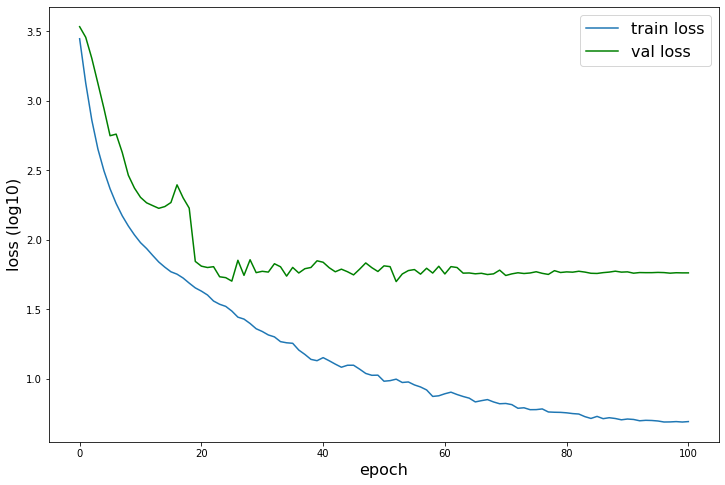

In [22]:
#x = df_loss['epoch'].values
x = df_loss.index.to_list() 
y1 = np.log10( df_loss['total_loss'].values  )
y2 = np.log10( df_loss_val['total_val_loss'].values )

plt.figure(figsize=(12,8))
plt.plot(x, y1, label='train loss')

plt.plot(df_loss_val.index.to_list() , y2, label='val loss', color='green')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss (log10)', fontsize=16)
plt.legend(fontsize=16)

#plt.xlim([300, 400])
#plt.ylim([0, 200])

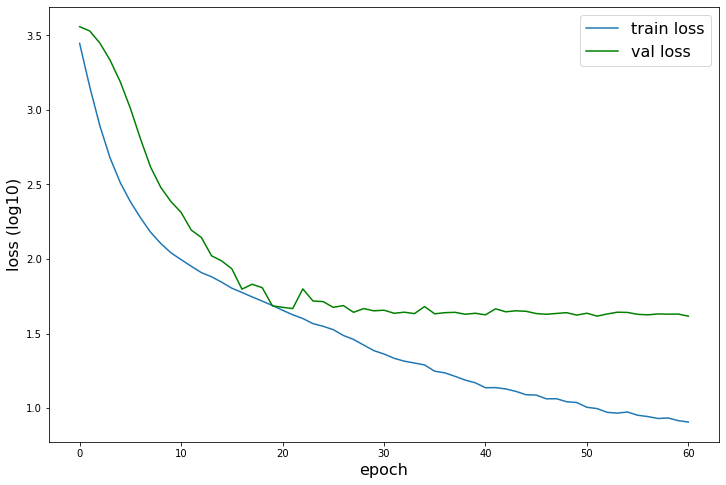

In [ ]:
#x = df_loss['epoch'].values
x = df_loss.index.to_list() 
y1 = np.log10( df_loss['total_loss'].values  )
y2 = np.log10( df_loss_val['total_val_loss'].values )

plt.figure(figsize=(12,8))
plt.plot(x, y1, label='train loss')

plt.plot(df_loss_val.index.to_list() , y2, label='val loss', color='green')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss (log10)', fontsize=16)
plt.legend(fontsize=16)

#plt.xlim([300, 400])
#plt.ylim([0, 200])

### Others

In [ ]:
def get_annot( annot_path = 'dataset/LEs920/train.txt'):
    """get annotation from dataset text"""
    with open(annot_path, 'r') as f:
        txt = f.readlines()
        annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
    resdic = {}
    for ann in annotations:
        ann = ann.split(' ')
        image_path = ann[0]
        boxarr = []
        for a in ann[1:]:
            box = np.fromstring(a, sep=',')
            boxarr.append(box)
        boxarr = np.array(boxarr)
        resdic[image_path] = boxarr

    return resdic


In [ ]:
anndic = get_annot("dataset/LEs576aug/train_aug1_s.txt")

imgfiles = list( anndic.keys() )


In [ ]:
#x = df_loss['epoch'].values
x = df_loss.index.to_list() 
y1 = df_loss['total_loss'].values  
y2 = df_val_loss['total_val_loss'].values 

plt.figure(figsize=(12,8))
plt.plot(x, y1, label='train loss')
plt.plot(x, y2, label='val loss')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.legend(fontsize=16)

#plt.xlim([300, 400])
#plt.ylim([0, 200])

In [ ]:
ls 'checkpoints'

checkpoint
yolov3_LE576_fits_aug.data-00000-of-00001
yolov3_LE576_fits_aug.index
yolov3_LE576_fits.data-00000-of-00001
yolov3_LE576_fits_giou.data-00000-of-00001
yolov3_LE576_fits_giou.index
yolov3_LE576_fits.index


In [ ]:
input_size = 576
yolo_ = Create_Yolov3(input_size=input_size, CLASSES=TRAIN_CLASSES)
yolo_.load_weights("./checkpoints/yolov3_LE576_fits_aug") # use weights

In [ ]:
Pred_xywh[1,1,1,1,:4]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([12.090325, 11.983248, 16.142168, 30.511854], dtype=float32)>

In [ ]:
tf.add( Label_xywh[...,:4] , Pred_xywh[...,:4])[1,1,1,1,:4]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([12.090325, 11.983248, 16.142168, 30.511854], dtype=float32)>

In [ ]:
Label_xywh[1,1,1,1,:4]

array([0., 0., 0., 0.], dtype=float32)

#### test iou+ncorners

In [ ]:
Pred_xywh.shape, Label_xywh.shape

(TensorShape([4, 72, 72, 3, 4]), (4, 72, 72, 3, 4))

In [ ]:
BOX1.shape, BOX1.shape

(TensorShape([4, 72, 72, 3, 4]), TensorShape([4, 72, 72, 3, 4]))

In [ ]:
boxes1 = Pred_xywh
boxes2 = Label_xywh

# box [x, y, w, h], x,y: center of box
boxes1_area = boxes1[..., 2] * boxes1[..., 3]
boxes2_area = boxes2[..., 2] * boxes2[..., 3]

#[, 4]
boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                    boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                    boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1) 

left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])
inter_section = tf.maximum(right_down - left_up, 0.0)
inter_area = inter_section[..., 0] * inter_section[..., 1]
union_area = boxes1_area + boxes2_area - inter_area
iou = 1.0 * inter_area / union_area



In [ ]:
# boxes2 contains boxes1 
idx_4corners_2in1 = ( boxes1[..., 0] > boxes2[..., 0] ) & ( boxes1[..., 3] < boxes2[..., 3] ) \
    & ( boxes1[..., 1] > boxes2[..., 1]) & ( boxes1[..., 2] < boxes2[..., 2] )

# two corners inside 
idx_2corners_2in1 = ( boxes1[..., 0] > boxes2[..., 0] ) & ( boxes1[..., 3] < boxes2[..., 3] ) \
    & ( boxes1[..., 1] > boxes2[..., 1]) & ( boxes1[..., 2] < boxes2[..., 2] )



In [ ]:
boxes1.shape

TensorShape([4, 72, 72, 3, 4])

In [ ]:
( tf.cast( idx, tf.float32) + iou ) [tf.cast( idx, tf.float32) !=0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([1.6173718, 1.4330602, 1.3622375, 1.5955521, 1.4870508, 1.3547771,
       1.1741369], dtype=float32)>

In [ ]:
iou [idx]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([0.6173718 , 0.43306014, 0.36223742, 0.5955521 , 0.48705083,
       0.3547771 , 0.17413694], dtype=float32)>

In [ ]:
boxes2[idx]

<tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[331., 395., 367., 431.],
       [433., 474., 467., 508.],
       [  2.,  10.,  38.,  46.],
       [  2.,  10.,  38.,  46.],
       [ 75., 543., 126., 574.],
       [274., 249., 310., 285.],
       [378., 485., 414., 521.]], dtype=float32)>

In [ ]:
boxes1[idx]

<tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[336.0583   , 395.53937  , 359.90448  , 429.09247  ],
       [443.80197  , 476.74915  , 460.22537  , 507.23114  ],
       [ 12.091755 ,  13.318158 ,  28.092537 ,  42.657955 ],
       [  2.5890045,  17.01352  ,  37.30078  ,  39.249073 ],
       [ 83.55544  , 544.30975  , 116.41508  , 567.7436   ],
       [284.87225  , 252.06932  , 299.24316  , 284.0639   ],
       [390.73288  , 487.53088  , 400.522    , 510.5852   ]],
      dtype=float32)>

In [ ]:
import cv2

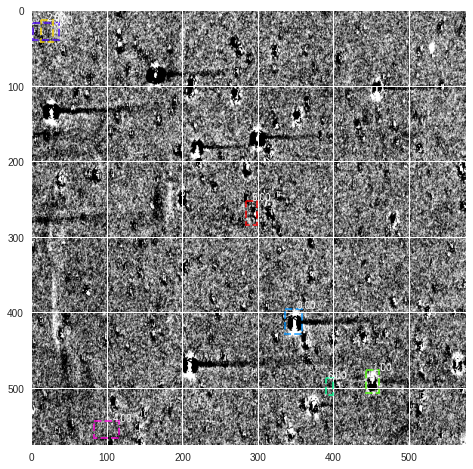

In [ ]:
plot_bboxes(image_path='./dataset/LEs576aug/tiles_aug/009_2_fliph_r90.jpg', labels=np.arange(7), bboxes=boxes1[idx])


In [ ]:
boxes2 [ boxes2[...,0] != 0 ]

In [ ]:
def fits_to_uint8(fitsarr, vmin=-1, vmax=1,):
    
    # clip
    data = np.clip(fitsarr, vmin, vmax)
    # scale to [0,1]
    data = (data - vmin) / (vmax - vmin)
    # convert to uint8
    data = (255 * data).astype(np.uint8)
    # invert y axis
    #data = data[::-1, :]
    return data


In [ ]:
boxes2.shape

TensorShape([4, 72, 72, 3, 4])

./dataset/LEs576aug/tiles_aug/009_2_fliph_r90.fits.npz
./dataset/LEs576aug/tiles_aug/008_2_r90.fits.npz



./dataset/LEs576aug/tiles_aug/012_0_r270.fits.npz
./dataset/LEs576aug/tiles_aug/006_0_fliph.fits.npz


./dataset/LEs576aug/tiles_aug/009_2_fliph_r90.fits.npz


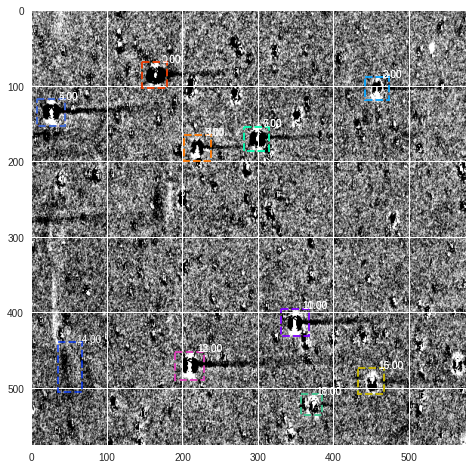

In [ ]:

batch0 = boxes2[0]
bx = batch0 [ batch0[...,1] != 0 ]
plot_bboxes(image_path='./dataset/LEs576aug/tiles_aug/009_2_fliph_r90.jpg', readfits=True, labels=np.arange(len(bx)), bboxes=bx)



In [ ]:
while 1:pass

In [ ]:
img, box = next( trainset )

./dataset/LEs576aug/tiles_aug/007_0_flipv.fits.npz
./dataset/LEs576aug/tiles_aug/009_2_fliph_r270.fits.npz
./dataset/LEs576aug/tiles_aug/009_1_flipv_r90.fits.npz
./dataset/LEs576aug/tiles_aug/012_2_r90.fits.npz


In [ ]:
box[0][0].shape, box[1][0].shape, box[2][0].shape

((4, 72, 72, 3, 7), (4, 36, 36, 3, 7), (4, 18, 18, 3, 7))

In [ ]:
batch0 = boxes2[0]
bx = batch0 [ batch0[...,1] != 0 ]

In [ ]:
idx.shape

TensorShape([4, 72, 72, 3])

./dataset/LEs576aug/tiles_aug/012_0_r270.fits.npz


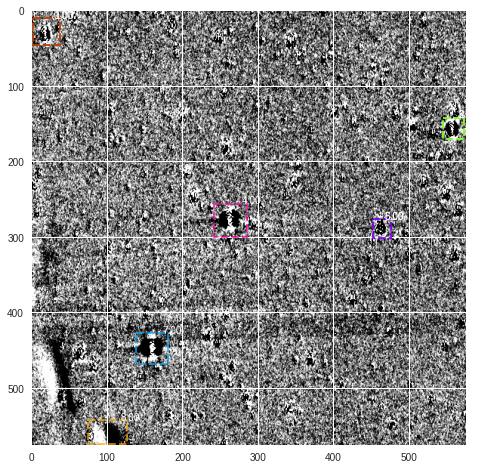

In [ ]:
batch0 = boxes2[2]
bx = batch0 [ batch0[..., 2] != 0 ]
plot_bboxes(image_path='./dataset/LEs576aug/tiles_aug/012_0_r270.jpg', readfits=True, labels=np.arange(len(bx)), bboxes=bx)


In [ ]:
left_up.shape

TensorShape([4, 72, 72, 3, 2])

In [ ]:
inter_area.shape

TensorShape([4, 72, 72, 3])

In [ ]:
Label_xywh[Label_xywh!=0]

In [ ]:
#global to store tensor value
#Pred_xywh = 0
#Label_xywh = 0
#BOX1 = 0
#BOX2 = 0

In [ ]:
BOX1.shape

TensorShape([4, 72, 72, 3, 4])

In [ ]:
Label_xywh.shape

(4, 72, 72, 3, 4)

In [ ]:
BOX1

0

In [ ]:
Label_xywh[1,1,1,1,:4]

array([0., 0., 0., 0.], dtype=float32)

#### detect

In [ ]:
import cv2
import colorsys
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import colorsys
import random
def image_preprocess(image, target_size, gt_boxes=None):
    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes


def postprocess_boxes(pred_bbox, original_image, input_size, score_threshold):
    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # 1. (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # 2. (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = original_image.shape[:2]
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # 3. clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # 4. discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # 5. discard boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)

    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]
        # Process 1: Determine whether the number of bounding boxes is greater than 0 
        while len(cls_bboxes) > 0:
            # Process 2: Select the bounding box with the highest score according to socre order A
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            # Process 3: Calculate this bounding box A and
            # Remain all iou of the bounding box and remove those bounding boxes whose iou value is higher than the threshold 
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

def draw_bbox(image, bboxes, CLASSES="./model_data/coco.names", show_label=True, show_confidence = True, Text_colors=(255,255,0), rectangle_colors=''):   
    NUM_CLASS = read_class_names(CLASSES)
    num_classes = len(NUM_CLASS)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    #print("hsv_tuples", hsv_tuples)
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = rectangle_colors if rectangle_colors != ''else colors[class_ind]
        #bbox_thick = int(0.6 * (image_h + image_w) / 1000) / 15  
        bbox_thick = int(0.6 * (image_h + image_w) / 500)
        #if bbox_thick < 1: bbox_thick = 1
        #print(image_h, image_w, bbox_thick)
        fontScale = 0.75 * bbox_thick
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        # put object rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        if show_label:
            # get text label
            #score_str = f' {score:.2f}' if show_confidence else ''
            score_str = " {:.2f}".format(score) if show_confidence else "" 
            #label = f'{NUM_CLASS[class_ind]}' + score_str
            label = "{}".format(NUM_CLASS[class_ind]) + score_str

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)

    return image

def bboxes_iou(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

def read_class_names(class_file_name):
    # loads class name from a file
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names


In [ ]:
def fits_to_uint8(fitsarr, vmin=-5, vmax=5,):
    
    # clip
    data = np.clip(fitsarr, vmin, vmax)
    # scale to [0,1]
    data = (data - vmin) / (vmax - vmin)
    # convert to uint8
    data = (255 * data).astype(np.uint8)
    # invert y axis
    #data = data[::-1, :]
    return data

def detect_(yolo, image_path = "./star/0.jpg", score_th=0.5, iou_nms=0.45, 
            showimg=False, readfits=False, showclassid=None):
    
    if readfits:
        fitspath = image_path.replace("jpg", "fits.npz")
        image_data = np.load(fitspath)["fitsarr"]
        print(fitspath)
        original_image = fits_to_uint8(image_data, vmin=-1, vmax=1)
        
    else:
        original_image      = cv2.imread(image_path)
        #original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)    
        image_data = image_preprocess(np.copy(original_image), [input_size, input_size])

    image_data = tf.expand_dims(image_data, 0)
    
    pred_bbox = yolo.predict(image_data)
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
        
    #bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold=score_th)
    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold=score_th)
    bboxes = nms(bboxes, iou_threshold=iou_nms, method='nms')
    if showclassid!=None:
        stacked_bboxes = np.stack(bboxes, axis=0)
    
        # draw only bboxes of classid 
        bboxes = stacked_bboxes [stacked_bboxes[:, 5] == showclassid, :]
    
    image = draw_bbox(original_image, bboxes, CLASSES=TRAIN_CLASSES, 
                      Text_colors=(255,0,0),
                      rectangle_colors=(128,255,0))
    
    if showimg:
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
    return np.array(bboxes)

In [ ]:
input_size = 576
yolo_ = Create_Yolov3(input_size=input_size, CLASSES=TRAIN_CLASSES)
yolo_.load_weights("./checkpoints/yolov3_LE576_fits_aug") # use weights

In [ ]:
# plot bounding box
def random_colors(N, bright=True):
    '''
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    '''
    import random
    import colorsys

    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def plot_bboxes(image_path, bboxes, labels=[], ax=None, figsize=(8, 8), readfits=False, title=None):
    """
    Draw bounding boxes on image
    img: img array
    bboxes: bounding boxes array, shape [n bboxes, 4]
    """
    import matplotlib.pyplot as plt
    from matplotlib import patches
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
    
    N = bboxes.shape[0]
    colors = random_colors(N)

    if readfits:
        fitspath = image_path.replace("jpg", "fits.npz")
        image_data = np.load(fitspath)["fitsarr"]
        print(fitspath)
        original_image = fits_to_uint8(image_data, vmin=-1, vmax=1)
        
    else:
        original_image      = cv2.imread(image_path)
        #original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)    
        #image_data = image_preprocess(np.copy(original_image), [input_size, input_size])

    ax.imshow(original_image)
    ax.set_title(title)
    for i in range(N):
        # for faster rcnn
        #y1, x1, y2, x2 = bboxes[i] [:4]
        #y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)

        # for yolo
        x1, y1, x2, y2 = bboxes[i][:4]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=colors[i], facecolor='none')
        ax.add_patch(p)
        
        # Label
        #class_id = class_ids[i]
        #score = scores[i] if scores is not None else None
        #label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{:.2f}".format( labels[i] )
        ax.text(x2 - 8, y1, caption,
                color='w', size=10, backgroundcolor="none")



./dataset/LEs576aug/tiles_aug/014_5_flipv.fits.npz


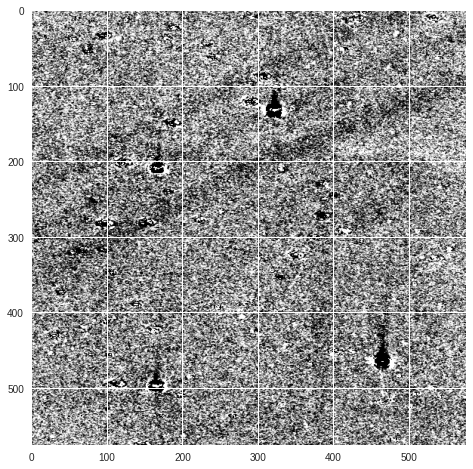

In [ ]:
boxes = detect_(yolo_, image_path = "./dataset/LEs576aug/tiles_aug/014_5_flipv.jpg", score_th=0.2, iou_nms=0.45, 
            showimg=True, readfits=True, showclassid=None)


In [ ]:
boxes

array([], dtype=float64)

In [ ]:
ls './dataset/LEs'

### prepare train/test dataset

In [ ]:
def get_annot(annot_path = 'dataset/LEs920/train.txt'):
    """get annotation from dataset text"""
    with open(annot_path, 'r') as f:
        txt = f.readlines()
        annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
    resdic = {}
    for ann in annotations:
        ann = ann.split(' ')
        image_path = ann[0]
        boxarr = []
        for a in ann[1:]:
            box = np.fromstring(a, sep=',')
            boxarr.append(box)
        boxarr = np.array(boxarr)
        resdic[image_path] = boxarr

    return resdic



In [ ]:
resdic = get_annot(annot_path='dataset/LEs576aug/all.txt')

In [ ]:
imgfiles = list(resdic.keys())

In [ ]:
np.random.seed(seed=0)
idxs = np.random.permutation( len(imgfiles) )

spl = int( 0.7 * len(imgfiles) )

idx_train = idxs[:spl]
idx_test = idxs[spl:]

In [ ]:
resdic[imgfiles[0]][:, 4]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
# split train, test
with open("./dataset/LEs576aug/train.txt", 'w') as f:

    for image_idx in idx_train:
        
        imgfile = imgfiles[image_idx]
        bboxes = resdic[ imgfile ]
        image_ann = imgfile
        print('trainset', image_ann)
        #cv2.imwrite(image_ann, rgb_img)
        for i in range( len(bboxes)):
            x1, y1, x2, y2 = bboxes[i][:4]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            xmin = str(x1)
            ymin = str(y1)
            xmax = str(x2)
            ymax = str(y2)
            class_ind = str( int( bboxes[i][4] ) )
            image_ann += ' ' + ','.join([xmin, ymin, xmax, ymax, class_ind])
        f.write(image_ann + "\n")

with open("./dataset/LEs576aug/test.txt", 'w') as f:

    for image_idx in idx_test:
        
        imgfile = imgfiles[image_idx]
        bboxes = resdic[ imgfile ]
        image_ann = imgfile
        print('testset', image_ann)
        #cv2.imwrite(image_ann, rgb_img)
        for i in range( len(bboxes)):
            x1, y1, x2, y2 = bboxes[i][:4]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            xmin = str(x1)
            ymin = str(y1)
            xmax = str(x2)
            ymax = str(y2)
            class_ind = str( int( bboxes[i][4] ) )
            image_ann += ' ' + ','.join([xmin, ymin, xmax, ymax, class_ind])
        f.write(image_ann + "\n")


In [ ]:
TRAIN_CLASSES, TRAIN_INPUT_SIZE, TRAIN_MODEL_NAME

('dataset/LEs576/LEs_name.txt', 576, 'yolov3_LE576_fits')